In [2]:
from itertools import combinations

import re
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
import kmeans1d
'''
kmeans1d

A Python library with an implementation of k-means clustering on 1D data, based on the algorithm in (Xiaolin 1991), as presented in section 2.2 of (Gronlund et al., 2017).

Globally optimal k-means clustering is NP-hard for multi-dimensional data. Lloyd's algorithm is a popular approach for finding a locally optimal solution. For 1-dimensional data, there are polynomial time algorithms. The algorithm implemented here is a O(kn + n log n) dynamic programming algorithm for finding the globally optimal k clusters for n 1D data points.

The code is written in C++, and wrapped with Python.
'''

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# shape (381109, 11)
data = pd.read_csv('datasets/d1.csv')
data = data.drop(['id'], axis=1)

# data_2 = pd.read_csv('datasets/d2.csv')

Gender                    2
Age                      54
Driving_License           1
Region_Code              42
Previously_Insured        2
Vehicle_Age               3
Vehicle_Damage            2
Annual_Premium          166
Policy_Sales_Channel     23
Vintage                 152
Response                  2
dtype: int64

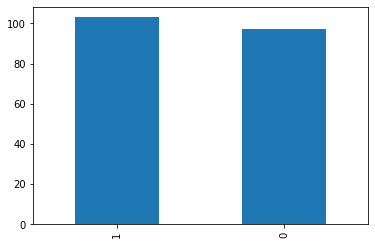

In [23]:

freq = pd.DataFrame({'Response':['0', '1'], 'nostoextract':[46710, 46710], })
def bootstrap(data, freq):
    freq = freq.set_index('Response')

    # This function will be applied on each group of instances of the same
    # class in `data`.
    def sampleClass(classgroup):
        cls = classgroup['Response'].iloc[0]
        nDesired = freq.nostoextract[cls]
        nRows = len(classgroup)

        nSamples = min(nRows, nDesired)
        return classgroup.sample(nSamples)

    samples = data.groupby('Response').apply(sampleClass)

    # If you want a new index with ascending values
    # samples.index = range(len(samples))

    # If you want an index which is equal to the row in `data` where the sample
    # came from
    samples.index = samples.index.get_level_values(1)

    # If you don't change it then you'll have a multiindex with level 0
    # being the class and level 1 being the row in `data` where
    # the sample came from.

    return samples

data = bootstrap(data,freq)
df = data.copy()
df = df.sample(200, random_state=24) # 24
df['Response'].value_counts().plot(kind='bar') 
df.nunique()


In [41]:
%%time


class Error(Exception):
    """Base class for other exceptions"""
    pass


class NotMatchResult(Error):
    """Raised when the input value is too small"""
    pass


class DRST:
    '''
        An Efficient Discretization Algorithm Using Rough Set Theory

        ...

        Attributes
        ----------
        checker_type : str='topN'
            Type of the checker of data to determind wether data column is Continous or Discrete

        Methods
        -------
        fit(x: DataFrame, continous_columns: list)

        Note
        -------

        Example
        -------


    '''

    def __init__(
        self, 
        checker_type: str = 'topN', 
        comb_max_depth: int = None
        ):
        # Primary Data Information
        self.data = None
        self.columns = None
        self.continuous_columns = None
        self.discrete_columns = None
        self.scaled_data = None

        # Secondary Data infromation
        self.data_after_INI = None
        self.silhouette_scores = None

        # check_discrete
        self.dis_check_threshold = 0.5
        self.dis_checker = checker_type  # ratio
        self.checker_top_n = 10  # defult number of top N for topN checker

        # Config Tools
        self.scaler = StandardScaler()
        self.natural_interval_model = 'kmeans'
        self.NIM_message = 'Model for initiat the natural intervals cannot be blank'
        self.comb_max_depth = comb_max_depth
        self.all_combinations = None

    def fit(
            self,
            x: pd.DataFrame,
            continous_columns: list = [],
            natural_interval_model: str = 'kmeans'
    ):
        """Discretization using Rough Sets Theory (RST).

        Fit `x` to an efficient intervals using the concept of RST 
        * asd
        Parameters
        ----------
        x : DataFrame
            Full DataFrame (default is None)

        continous_columns : list
            Determind names of column(s) in the DataFarme as Continuous data. If `None` a function _check_continuous triger to determind names of column(s).

        Raises
        ------
        NotMatchResult
            If continous_columns `~None` model check the input with the checker determation if didn't match the result

        """

        # Reduct Data Intervals phase: Pre-process of discretization, intiate classification
        # Pre-process of discretization
        self.data = x
        self.columns = self.data.columns
        self.continuous_columns = continous_columns if continous_columns else self._check_continuous()
        self.discrete_columns = list(set(self.columns).difference(self.continuous_columns))
        
        self.scaled_data = self._scaling_continuous()
        self.silhouette_scores = self._get_silhouette_score()
        # print(self.silhouette_scores)

        # Intiate classification
        self.data_after_INI = getattr(self, '_%s_model' % natural_interval_model, lambda: self.NIM_message)()
        # print(self.data_after_INI.nunique())
        self.data_after_INI.sort_values(['Annual_Premium']).to_csv('%s_model.csv' % natural_interval_model)
        self.all_combinations = self.get_combinations()

        data = self.data.copy()
        data[self.continuous_columns] = self.data_after_INI.to_numpy()
        return data
    
    def _dbscan_model(self):
        result = {}
        for att in self.continuous_columns:
            clustering = DBSCAN(eps=1, min_samples=5).fit(
                self._np_array_reshaped(self.data[att])
            )
            result[att] = clustering.labels_
        return pd.DataFrame(result)

    def _kmeans_model(self):
        result = {}
        for att in self.continuous_columns:
            clustering = KMeans(n_clusters=self.silhouette_scores[att]).fit(
                self._np_array_reshaped(self.scaled_data[att])
            )
            result[att] = clustering.labels_
        return pd.DataFrame(result)

    def _np_array_reshaped(self, data, reshape=(-1, 1)):
        return np.array(data.tolist()).reshape(reshape[0], reshape[1])

    def _check_continuous(self, continous_columns: list = []):
        top_n = self.checker_top_n
        likely = []

        # check if attribute is continuous or discrete dataframe
        for var in self.data.columns:
            if self.dis_checker == 'topN':
                # Check if the top n unique values account for more than a certain proportion of all values
                if 1.*self.data[var].value_counts(normalize=True).head(top_n).sum() < 0.5:
                    likely.append(var)
            elif self.dis_checker == 'ratio':
                # Find the ratio of number of unique values to the total number of unique values. Something like the following
                if 1.*self.data[var].nunique()/self.data[var].count() > 0.5:
                    likely.append(var)

        common_names = ['id']
        
        return [x for x in likely if x.lower() not in common_names]

    def _scaling_continuous(self):
        
        data_cluster = self.data[self.continuous_columns].copy()
        scaled_columns = self.scaler.fit_transform(data_cluster)
        self.scaled_data = self.data.copy()
        self.scaled_data[self.continuous_columns] = scaled_columns

        return self.scaled_data
        
    def _get_silhouette_score(self):
        scores = {}
        for att in self.continuous_columns:
            temp_score = []
            scores[att] = 3
            for n_clusters in range(3,9):
                # Initialize the clusterer with n_clusters value and a random generator
                # seed of 10 for reproducibility.
                clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                cluster_labels = clusterer.fit_predict(self._np_array_reshaped(self.scaled_data[att]))

                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                silhouette_avg = silhouette_score(self._np_array_reshaped(self.scaled_data[att]), cluster_labels)
                temp_score.append(silhouette_avg)
            scores[att] = temp_score.index(max(temp_score)) + 3
        return scores
    
    def get_combinations(self, comb_max_depth: int = None):
        if not comb_max_depth:
            comb_max_depth = self.comb_max_depth
        combX = []
        for idx, _ in enumerate(self.discrete_columns):
            if comb_max_depth and comb_max_depth == idx:
                break
            combX.extend(list(combinations(self.discrete_columns, idx + 1)))

        return sorted(combX, key=len)

drst = DRST()
# drst.fit(data_1, natural_interval_model='kmeans', continous_columns=['months_as_customer','total_claim_amount'])
# drst.fit(data_1, natural_interval_model='kmeans')

drst_fit = drst.fit(df)
drst_fit

CPU times: total: 3.38 s
Wall time: 830 ms


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
140358,Female,1,1,46.0,1,< 1 Year,No,2,152.0,2,0
145987,Female,1,1,25.0,0,< 1 Year,Yes,0,152.0,1,0
153353,Female,4,1,36.0,0,1-2 Year,Yes,2,26.0,0,1
15594,Female,3,1,28.0,0,> 2 Years,Yes,2,3.0,0,1
218355,Female,1,1,10.0,1,< 1 Year,No,0,152.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
29071,Male,2,1,28.0,0,> 2 Years,Yes,2,124.0,0,1
316521,Female,7,1,28.0,0,> 2 Years,Yes,2,26.0,2,0
5548,Female,1,1,18.0,0,< 1 Year,Yes,0,160.0,1,0
48321,Female,3,1,28.0,0,1-2 Year,Yes,0,156.0,0,0
